In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

In [5]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [6]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [7]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [ ]:
class PINN():
    def __init__(self, X, u, layers, bc):

        # data 
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        # deep neural network
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.01)


In [8]:
def generate_points(p):
    pd = p[0]
    pb = p[1]
    pi = p[2]

    # domain
    t = np.random.uniform(0, 2*np.pi, pd)
    r = np.sqrt(np.random.uniform(0, 1, pd))
    xd = r * np.cos(t)
    yd = r * np.sin(t)
    td = np.random.uniform(0, 1, pd)

    # boundary
    t = np.random.uniform(0, 2*np.pi, pb)
    xb = np.cos(t)
    yb = np.sin(t)
    tb = np.random.uniform(0, 1, pb)

    # initial
    t = np.random.uniform(0, 2*np.pi, pi)
    r = np.sqrt(np.random.uniform(0, 1, pi))
    xi = r * np.cos(t)
    yi = r * np.sin(t)
    ti = np.zeros(pi)

    X = {'dom': xd, 'bc': xb, 'ic': xi}
    Y = {'dom': yd, 'bc': yb, 'ic': yi}
    T = {'dom': td, 'bc': tb, 'ic': ti}

    return X, Y, T

(10000, 1)
(10000, 1)


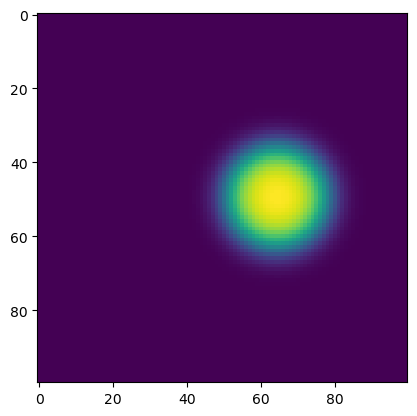

In [21]:
# p = [1000, 100, 100]
# x, y, t = generate_points(p)

x0 = 0.3
y0 = 0
r0 = 0.25

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

x_flat = X.flatten().reshape(-1, 1)
y_flat = Y.flatten().reshape(-1, 1)
print(x_flat.shape)
f = lambda x, y: 1/2 * (1 - np.tanh(((x - x0)**2 + (y - y0)**2)/r0**2 - 1))
ic = f(x_flat, y_flat)
print(ic.shape)
IC = ic.reshape(100, 100)

plt.imshow(IC)
